<a href="https://colab.research.google.com/github/Passssa/Labs-of-Machine-Learning/blob/main/Lab2/Lab2_Pashnina_16var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### `Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   
`Выполнила Пашнина Алёна (16 вариант)` 


# Лабораторная работа №3: Линейные модели. Кросс-валидация. 


*Модели*: множественная линейная регрессия 

*Данные*: `insurance` (источник: <https://www.kaggle.com/mirichoi0218/insurance/version/1>)

In [73]:
# Загружаем нужные пакеты:

# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

# константы
#  ядро для генератора случайных чисел
my_seed = 9212
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

### Далее загрузим наши данные для работы

Набор данных `insurance` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/insurance.csv>. 
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [74]:
# читаем таблицу расширения .csv во фрейм
DF_raw = pd.read_csv('https://raw.githubusercontent.com/ania607/ML/main/data/College_for_lab.csv')

# выясняем размерность фрейма
DF_raw.shape

(777, 9)

In [75]:
# выводим первые несколько строк таблицы
DF_raw.head(5)


,Grad_Rate,Accept,Top10perc,Top25perc,F_Undergrad,P_Undergrad,PhD,Expend,Private
0,60,1232,23,52,2885,537,70,7041,Yes
1,56,1924,16,29,2683,1227,29,10527,Yes
2,54,1097,22,50,1036,99,53,8735,Yes
3,59,349,60,89,510,63,92,19016,Yes
4,15,146,16,44,249,869,76,10922,Yes


In [76]:
DF_raw.dtypes #типы заначений в столбцах

Grad_Rate       int64
Accept          int64
Top10perc       int64
Top25perc       int64
F_Undergrad     int64
P_Undergrad     int64
PhD             int64
Expend          int64
Private        object
dtype: object

In [77]:
# Проверим нашу модель на качество
print(DF_raw.isnull().sum()+DF_raw.isna().sum())
DF_raw.info()

Grad_Rate      0
Accept         0
Top10perc      0
Top25perc      0
F_Undergrad    0
P_Undergrad    0
PhD            0
Expend         0
Private        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Grad_Rate    777 non-null    int64 
 1   Accept       777 non-null    int64 
 2   Top10perc    777 non-null    int64 
 3   Top25perc    777 non-null    int64 
 4   F_Undergrad  777 non-null    int64 
 5   P_Undergrad  777 non-null    int64 
 6   PhD          777 non-null    int64 
 7   Expend       777 non-null    int64 
 8   Private      777 non-null    object
dtypes: int64(8), object(1)
memory usage: 54.8+ KB


Отсутствуют пустые(или нулевые по значению) ячейки и количество наблюдений по столбцам одинаковое. Данные в таблице пригодны для анализа.

### Задание 1. Делим наш фрейм на обучение и тесты. 
Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели. Также согласно варианту 16, оставляет только нужные столбцы

In [78]:
# кодируем категориальные переменные
# private 
# 1 -  частный(yes), 0 - государственный(no) университет
private_dict = {'Yes' : 1, 'No' : 0}
DF_raw['PrivateYes'] = DF_raw.Private.map(private_dict)
DF_raw

,Grad_Rate,Accept,Top10perc,Top25perc,F_Undergrad,P_Undergrad,PhD,Expend,Private,PrivateYes
0,60,1232,23,52,2885,537,70,7041,Yes,1
1,56,1924,16,29,2683,1227,29,10527,Yes,1
2,54,1097,22,50,1036,99,53,8735,Yes,1
3,59,349,60,89,510,63,92,19016,Yes,1
4,15,146,16,44,249,869,76,10922,Yes,1
...,...,...,...,...,...,...,...,...,...,...
772,40,1515,4,26,3089,2029,60,4469,No,0
773,83,1805,24,47,2849,1107,73,9189,Yes,1
774,49,1915,34,61,2793,166,67,8323,Yes,1
775,99,2453,95,99,5217,83,96,40386,Yes,1


In [81]:
# оставляет только нужные перерменные

DF_all = DF_raw[['Grad_Rate', 'Accept', 'Expend', 'PrivateYes']]

DF_all

,Grad_Rate,Accept,Expend,PrivateYes
0,60,1232,7041,1
1,56,1924,10527,1
2,54,1097,8735,1
3,59,349,19016,1
4,15,146,10922,1
...,...,...,...,...
772,40,1515,4469,0
773,83,1805,9189,1
774,49,1915,8323,1
775,99,2453,40386,1


Здесь:
* **Grad_Rate**- выпускной балл;
* **Accept**– количество реализованных заявок на поступление;
* **Expend**– расходы на обучение на одного студента;
* **PrivateYes**– государственный или частный университет (1, если частный);

In [82]:
# удаляем фрейм-исходник
del DF_raw

In [83]:
# данные для построения моделей, оставляем 80%
DF = DF_all.sample(frac=0.8, random_state=my_seed)

# данные для прогнозов
DF_predict = DF_all.drop(DF.index)

## Задание 2.Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что все переменные сильно отличаются по масштабу.

In [100]:
# описательные статистики для непрерывных переменных
DF[['Grad_Rate', 'Accept', 'Expend']].describe()

,Grad_Rate,Accept,Expend
count,622.000000,622.000000,622.000000
mean,64.911576,1978.663987,9682.720257
std,17.296046,2461.590744,5414.968113
min,10.000000,72.000000,3186.000000
25%,53.000000,573.000000,6742.500000
50%,65.000000,1090.500000,8412.000000
75%,77.000000,2295.000000,10807.750000
max,118.000000,26330.000000,56233.000000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

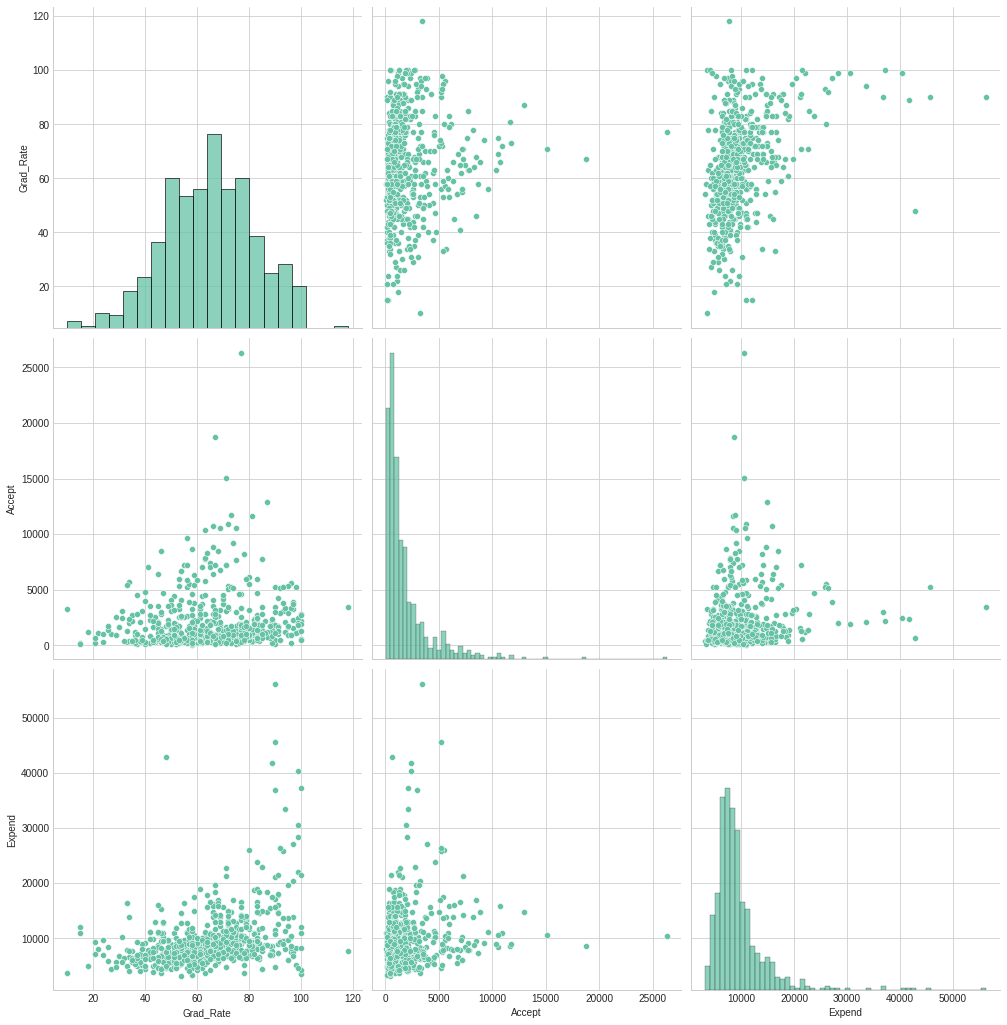

In [102]:
# матричный график разброса с линиями регрессии
g = sns.pairplot(DF[['Grad_Rate', 'Accept', 'Expend']])
g.fig.set_size_inches(15,15)
plt.show()


Судя по этим графикам:  
* распределение зависимой `Accept` не является нормальным;  
* `Expend` и `Grad_Rate` распределены нормально;  
* облако наблюдений на графиках представляет собой одну часть и одиночные выбросы;  
* в объясняющих переменных отсутствуют дискретные;  
* с увеличением значения `Grad_rate` разброс значений `Expend` и `Accept` увеличивается (также при достаточно высоком `Grad_rate` возможны выбросы у `Expend` и `Accept`). 

### Задание 3: Так как зависимая переменная распределена нормально, этап ее логарифмирования мы опускаем. Проверка на нормальность приведена ниже.

In [128]:
# тестируем на нормальность
for col in ['Grad_Rate']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

Grad_Rate Statistics=1.00, p=0.0706
Распределение нормально (H0 не отклоняется)



Наблюдаемые закономерности могут объясняться влиянием одной или нескольких из объясняющих переменных. Построим график, раскрасив точки цветом в зависимости от типа университета. 

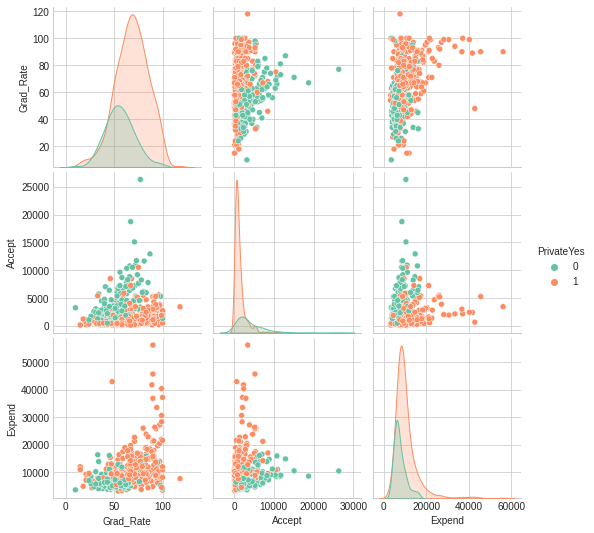

In [109]:
# матричный график разброса с цветом по типу университета (это единственная категориальная переменная в моем варианте)
sns.pairplot(DF[['Grad_Rate', 'Accept', 'Expend', 'PrivateYes']],
            hue='PrivateYes')

plt.show()
# напоминание: 0 - государственный, 1 - частный

Посмотрим на корреляционные матрицы непрерывных переменных фрейма.

In [110]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['Grad_Rate', 'Accept', 'Expend', 'PrivateYes']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  This is separate from the ipykernel package so we can avoid doing imports until


,Grad_Rate,Accept,Expend,PrivateYes
Grad_Rate,1.00,0.11,0.38,0.32
Accept,0.11,1.00,0.14,-0.46
Expend,0.38,0.14,1.00,0.23
PrivateYes,0.32,-0.46,0.23,1.00


Посчитаем корреляционные матрицы для студентов частного университета и государственного.  

In [117]:
# корреляционная матрица по частному университету
corr_mat = DF.loc[DF['PrivateYes'] == 1][['Grad_Rate', 'Accept', 'Expend']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

,Grad_Rate,Accept,Expend
Grad_Rate,1.000000,0.294261,0.350960
Accept,0.294261,1.000000,0.359962
Expend,0.350960,0.359962,1.000000


In [121]:
# корреляционная матрица по государственному университету
corr_mat = DF.loc[DF['PrivateYes'] == 0][['Grad_Rate', 'Accept', 'Expend']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

,Grad_Rate,Accept,Expend
Grad_Rate,1.000000,0.403190,0.276503
Accept,0.403190,1.000000,0.445364
Expend,0.276503,0.445364,1.000000


### Задание 4: Составить список возможных спецификаций моделей множественной регрессии
### Задание 5:  Оценить параметры моделей из списка. Оценить точность моделей методом перекрёстной проверки, указанным в варианте (LOOCV). Найти самую точную из моделей для Y.


#### Строим модели регрессии

##### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{Grad_Rate} = \hat{\beta_0} + \hat{\beta_1} \cdot PrivateYes + \hat{\beta_2} \cdot Accept + \hat{\beta_3} \cdot Expend$
1. `fit_lm_2`: $\hat{Grad_Rate} = \hat{\beta_0} + \hat{\beta_1} \cdot PrivateYes + \hat{\beta_2} \cdot Accept \cdot PrivateYes + \hat{\beta_3} \cdot Expend$
1. `fit_lm_3`: $\hat{Grad_Rate} = \hat{\beta_0} + \hat{\beta_1} \cdot PrivateYes + \hat{\beta_2} \cdot Expend \cdot PrivaterYes + \hat{\beta_3} \cdot Accept$
1. `fit_lm_4`: $\hat{Grad_Rate} = \hat{\beta_0} + \hat{\beta_1} \cdot PrivateYes + \hat{\beta_2} \cdot Expend \cdot PrivateYes + \hat{\beta_3} \cdot Accept \cdot PrivateYes$


##### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [129]:
# данные для модели 1
df1 = DF[['Grad_Rate', 'PrivateYes', 'Accept', 'Expend']]

# данные для модели 2
df2 = DF[['Grad_Rate', 'PrivateYes', 'Accept', 'Expend']]
df2.loc[:, 'Accept_PrivateYes'] = df2.loc[:, 'Accept'] * df2.loc[:, 'PrivateYes']
df2 = df2.drop(['Accept'], axis=1)

# данные для модели 3
df3 = DF[['Grad_Rate', 'PrivateYes', 'Accept', 'Expend']]
df3.loc[:, 'Expend_PrivateYes'] = df3.loc[:, 'Expend'] * df3.loc[:, 'PrivateYes']
df3 = df3.drop(['Expend'], axis=1)

# данные для модели 4
df4 = DF[['Grad_Rate', 'PrivateYes', 'Accept', 'Expend']]
df4.loc[:, 'Accept_PrivateYes'] = df4.loc[:, 'Accept'] * df4.loc[:, 'PrivateYes']
df4.loc[:, 'Expend_PrivateYes'] = df4.loc[:, 'Expend'] * df4.loc[:, 'PrivateYes']
df4 = df4.drop(['Expend', 'Accept'], axis=1)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [130]:
# проверка результатов
df4.head()

,Grad_Rate,PrivateYes,Accept_PrivateYes,Expend_PrivateYes
358,48,1,293,9754
767,59,0,0,0
444,48,0,0,0
677,68,1,8498,17007
110,58,1,72,10922


### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [136]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['Grad_Rate'], axis=1)
    y = df.Grad_Rate
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 9.92 секунд


Сравним ошибки для моделей на значениях `Grad_Rate`.  

In [139]:
scores

[-230.3515987869441,
 -237.05178852005875,
 -230.67194048265551,
 -240.85413110899648]

In [140]:
[np.around(-x, 2) for x in scores]

[230.35, 237.05, 230.67, 240.85]

Определим самые точные модели

In [148]:
fits = ['fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_1 :
MSE_loocv = 230.0


Самой точной среди моделей для `Grad_Rate` оказалась `fit_lm_1`. Но значение ошибки у `fit_lm_3` не сильно отличается. 

### Задание 6: Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [160]:
# прогноз по fit_lm_3
#  модель на всех обучающих наблюдениях
X = df3.drop(['Grad_Rate'], axis=1)
y = df3.Grad_Rate.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['Grad_Rate']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict[['PrivateYes', 'Accept', 'Expend']]
X.loc[:, 'Expend_PrivateYes'] = X.loc[:, 'Expend'] * X.loc[:, 'PrivateYes']
X = X.drop(['Expend'], axis=1)
#  прогнозы
y_pred = fit_lm_3.predict(X)

# ошибка
MSE3 = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_3 на отложенных наблюдениях = %.2f' % MSE3)

MSE модели fit_lm_3 на отложенных наблюдениях = 210.60


In [162]:
# прогноз по fit_lm_1
#  модель на всех обучающих наблюдениях
X = df1.drop(['Grad_Rate'], axis=1)
y = df1.Grad_Rate.values.reshape(-1, 1)
fit_lm_1 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['Grad_Rate']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict[['PrivateYes', 'Accept', 'Expend']]
# X.loc[:, 'Expend_PrivateYes'] = X.loc[:, 'Expend'] * X.loc[:, 'PrivateYes']
# X = X.drop(['Expend'], axis=1)
#  прогнозы
y_pred = fit_lm_1.predict(X)

# ошибка
MSE1 = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_1 на отложенных наблюдениях = %.2f' % MSE1)

MSE модели fit_lm_1 на отложенных наблюдениях = 212.24


In [163]:
np.sqrt(MSE1) / np.mean(DF_predict[['Grad_Rate']]) * 100

Grad_Rate    21.526462
dtype: float64

In [164]:
np.sqrt(MSE3) / np.mean(DF_predict[['Grad_Rate']]) * 100

Grad_Rate    21.442953
dtype: float64

Впринципе на всех этапах оценки точности модели, первая и третья показали практически одинаковые результаты. Можно принять любую из них. Для дополнительной проверки я возьму метод из другого варианта (например, K_VAL(n = 4), где n я перербирала различные, при 4 разница наиболее заметна)

In [186]:
# Перекрёстная проверка по 10 блокам
folds = 4

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 3)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df1, df3] :
    X = df.drop(['Grad_Rate'], axis=1)
    y = df.Grad_Rate
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.04 секунд


In [187]:
scores

[-233.54875827014303, -230.6978139462429]

In [188]:
# самая точная на charges
fits = ['fit_lm_1', 'fit_lm_3']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_3 :
MSE_kf10 = 231.0


Данный способ показал, что третья модель всё же меньше ошибается. Возьмем ее за итоговую и лучшую

In [197]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df3.drop(['Grad_Rate'], axis=1)
y = df3.Grad_Rate.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', fit_lm_3.intercept_,
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_3.coef_, 3))

модель fit_lm_0:
 константа  [48.58222263] 
 объясняющие  ['PrivateYes', 'Accept', 'Expend_PrivateYes'] 
 коэффициенты  [[8.337e+00 2.000e-03 1.000e-03]]


#### Интерпретация параметров модели

Y = 48.582 + 8.337PrivateYes + 0.002Accept - 0.001Expend_PrivateYes

Ошибка модели на отложенных наблюдениях составила 21.4% от среднего значения Y
Если объясняющие переменные будут равняться нулю, то Y равен константе = 48.582.
При увеличении Expend_PrivateYes на единицу, Y увеличится на 0.1. При увеличении Accept на единицу, Y увеличится на 0.002. При значении дискретной переменной PrivateYes = 1, Y увеличивается на 8.337, а при значении равном нулю, значение Y зависит только от непрерывных переменных.
Проверим нашу модель на выборке.

In [198]:
DF_predict.head(10)

,Grad_Rate,Accept,Expend,PrivateYes
0,60,1232,7041,1
1,56,1924,10527,1
3,59,349,19016,1
16,100,992,21424,1
21,70,4664,5854,0
23,48,10308,4602,0
51,56,184,8324,1
59,72,13007,16836,1
60,96,1019,20447,1
61,67,7333,6918,0


In [203]:
y_pred = fit_lm_3.predict(X[:10])
y_pred

array([[65.73930403],
       [51.98077875],
       [50.03955362],
       [87.33664496],
       [66.31332801],
       [67.52785122],
       [63.6511539 ],
       [51.43475034],
       [63.83828669],
       [65.55355838]])

Вприницпе, значения Y в отложенной выборке (табличка выше) и предсказанные моделью значения довольно схожи